In [176]:
# Data collection
import pandas_datareader as pdr

In [177]:
# Tiingo key
key = "077d0bda9b799940f089b43980c7c1be5443f407"

In [178]:
df = pdr.get_data_tiingo('AAPL', api_key = key)

<ipython-input-178-036d639a4a7c>:1: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only.
  df = pdr.get_data_tiingo('AAPL', api_key = key)


In [179]:
df.to_csv('AAPL.csv')

In [180]:
import pandas as pd

In [181]:
df = pd.read_csv('AAPL.csv')

In [182]:
df.head()
#from date 04/09/2018

,symbol,date,close,high,low,open,volume,adjClose,adjHigh,adjLow,adjOpen,adjVolume,divCash,splitFactor
0,AAPL,2018-09-04 00:00:00+00:00,228.36,229.18,226.63,228.41,27390132,54.673002,54.869323,54.258813,54.684973,109560528,0.0,1.0
1,AAPL,2018-09-05 00:00:00+00:00,226.87,229.67,225.10,228.99,33332960,54.316273,54.986637,53.892507,54.823834,133331840,0.0,1.0
2,AAPL,2018-09-06 00:00:00+00:00,223.10,227.35,221.30,226.23,34289976,53.413675,54.431192,52.982726,54.163047,137159904,0.0,1.0
3,AAPL,2018-09-07 00:00:00+00:00,221.30,225.37,220.71,221.85,37619810,52.982726,53.957149,52.841471,53.114405,150479240,0.0,1.0
4,AAPL,2018-09-10 00:00:00+00:00,218.33,221.85,216.47,220.95,39516453,52.271661,53.114405,51.826348,52.898931,158065812,0.0,1.0


In [183]:
df.tail()
#till date 31/08/2023

,symbol,date,close,high,low,open,volume,adjClose,adjHigh,adjLow,adjOpen,adjVolume,divCash,splitFactor
1252,AAPL,2023-08-25 00:00:00+00:00,178.61,179.15,175.820,177.380,51449594,178.61,179.15,175.820,177.380,51449594,0.0,1.0
1253,AAPL,2023-08-28 00:00:00+00:00,180.19,180.59,178.545,180.090,43820697,180.19,180.59,178.545,180.090,43820697,0.0,1.0
1254,AAPL,2023-08-29 00:00:00+00:00,184.12,184.90,179.500,179.695,53003948,184.12,184.90,179.500,179.695,53003948,0.0,1.0
1255,AAPL,2023-08-30 00:00:00+00:00,187.65,187.85,184.740,184.940,60813888,187.65,187.85,184.740,184.940,60813888,0.0,1.0
1256,AAPL,2023-08-31 00:00:00+00:00,187.87,189.12,187.480,187.840,60794467,187.87,189.12,187.480,187.840,60794467,0.0,1.0


In [184]:
df1 = df.reset_index()['close']

In [185]:
df1.shape

(1257,)

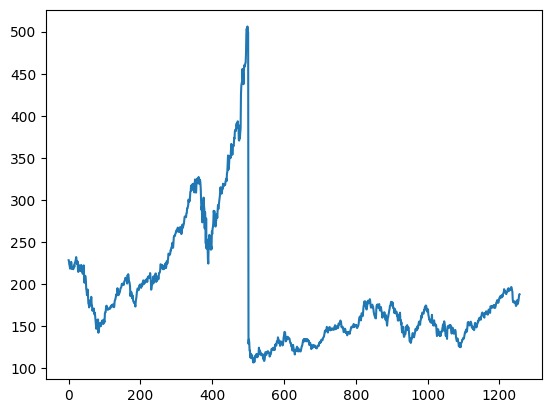

In [186]:
import matplotlib.pyplot as plt
plt.plot(df1)

In [187]:
import numpy as np

In [188]:
#since LSTM are sensitive to the scale of the data, we will apply MinMax scaler

from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler(feature_range = (0,1))
df1 = scaler.fit_transform(np.array(df1).reshape(-1,1))

In [189]:
df1.shape

(1257, 1)

In [190]:
#splitting dataset into train and test
#since it was a time series data hence we will not have random split, we will split according to the dates
training_size = int(len(df1)*0.65)
test_size = len(df1) - training_size
train_data, test_data = df1[0:training_size, :], df1[training_size:len(df1), :]

In [191]:
training_size, test_size

(817, 440)

In [192]:
def create_dataset(dataset, time_step = 1):
  dataX, dataY = [], []
  for i in range(len(dataset) - time_step):
    a = dataset[i:(i+time_step), 0]
    dataX.append(a)
    dataY.append(dataset[i + time_step, 0])
  return np.array(dataX), np.array(dataY)

#time_step = 2
#dataset = 120, 130, 140, 145, 156
#Input = 120, 130 | Output = 140
#Input = 130, 140 | Output = 145
#Input = 140, 145 | Output = 156

In [193]:
#reshape data

time_step = 100
X_train, y_train = create_dataset(train_data, time_step)
X_test, y_test = create_dataset(test_data, time_step)

In [194]:
X_train

array([[0.3043707 , 0.3006387 , 0.29119599, ..., 0.11486537, 0.12753914,
        0.12388228],
       [0.3006387 , 0.29119599, 0.28668754, ..., 0.12753914, 0.12388228,
        0.11982467],
       [0.29119599, 0.28668754, 0.27924859, ..., 0.12388228, 0.11982467,
        0.14629931],
       ...,
       [0.09450219, 0.09117095, 0.09585473, ..., 0.13570445, 0.13668128,
        0.13800877],
       [0.09117095, 0.09585473, 0.09432686, ..., 0.13668128, 0.13800877,
        0.12515967],
       [0.09585473, 0.09432686, 0.09718222, ..., 0.13800877, 0.12515967,
        0.13375078]])

In [195]:
X_train.shape, y_train.shape

((717, 100), (717,))

In [196]:
X_test.shape, y_test.shape

((340, 100), (340,))

Creating a stacked LSTM model

In [197]:
#reshaping into 3 dimensions for LSTM
X_train = X_train.reshape(X_train.shape[0], X_train.shape[1], 1)
X_test = X_test.reshape(X_test.shape[0], X_test.shape[1], 1)

In [198]:
#Creating LSTM model
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import LSTM

In [199]:
model = Sequential()
model.add(LSTM(50, return_sequences = True, input_shape = (100,1)))
model.add(LSTM(50, return_sequences = True))
model.add(LSTM(50))
model.add(Dense(1))
model.compile(loss = 'mean_squared_error', optimizer = 'adam')

In [200]:
model.summary()

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_12 (LSTM)              (None, 100, 50)           10400     
                                                                 
 lstm_13 (LSTM)              (None, 100, 50)           20200     
                                                                 
 lstm_14 (LSTM)              (None, 50)                20200     
                                                                 
 dense_4 (Dense)             (None, 1)                 51        
                                                                 
Total params: 50,851
Trainable params: 50,851
Non-trainable params: 0
_________________________________________________________________


In [201]:
model.fit(X_train, y_train, validation_data = (X_test, y_test), epochs = 100, batch_size = 64, verbose = 1)

Epoch 1/100
12/12 [==============================] - 9s 132ms/step - loss: 0.0482 - val_loss: 0.0019
Epoch 2/100
12/12 [==============================] - 0s 25ms/step - loss: 0.0175 - val_loss: 0.0031
Epoch 3/100
12/12 [==============================] - 0s 21ms/step - loss: 0.0119 - val_loss: 5.9038e-04
Epoch 4/100
12/12 [==============================] - 0s 21ms/step - loss: 0.0106 - val_loss: 0.0013
Epoch 5/100
12/12 [==============================] - 0s 22ms/step - loss: 0.0100 - val_loss: 3.2923e-04
Epoch 6/100
12/12 [==============================] - 0s 22ms/step - loss: 0.0088 - val_loss: 3.6643e-04
Epoch 7/100
12/12 [==============================] - 0s 22ms/step - loss: 0.0082 - val_loss: 3.7638e-04
Epoch 8/100
12/12 [==============================] - 0s 22ms/step - loss: 0.0068 - val_loss: 5.9822e-04
Epoch 9/100
12/12 [==============================] - 0s 22ms/step - loss: 0.0064 - val_loss: 2.9954e-04
Epoch 10/100
12/12 [==============================] - 0s 23ms/step - loss: 

In [202]:
import tensorflow as tf

In [203]:
tf.__version__

'2.12.0'

Predicting over the test data and plotting the output

In [204]:
train_predict = model.predict(X_train)
test_predict = model.predict(X_test)

11/11 [==============================] - 0s 8ms/step


In [205]:
#since we scaled the data before so we will have to rescale it back so as to calculate the RMSE
train_predict = scaler.inverse_transform(train_predict)
test_predict = scaler.inverse_transform(test_predict)

In [206]:
#RMSE performance matrix
import math
from sklearn.metrics import mean_squared_error
math.sqrt(mean_squared_error(y_train, train_predict))

221.55302476072464

In [207]:
math.sqrt(mean_squared_error(y_test, test_predict))

160.3913559465664

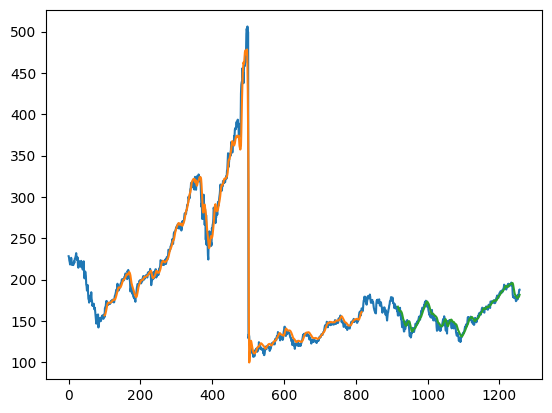

In [208]:
### Plotting
# shift train predictions for plotting
look_back=100
trainPredictPlot = np.empty_like(df1)
trainPredictPlot[:, :] = np.nan
trainPredictPlot[look_back:len(train_predict)+look_back, :] = train_predict
# shift test predictions for plotting
testPredictPlot = np.empty_like(df1)
testPredictPlot[:, :] = np.nan
testPredictPlot[len(train_predict)+(look_back*2):len(df1), :] = test_predict
# plot baseline and predictions
plt.plot(scaler.inverse_transform(df1))
plt.plot(trainPredictPlot)
plt.plot(testPredictPlot)
plt.show()

In [209]:
len(test_data)

440

In [210]:
x_input = test_data[340:].reshape(1, -1)
x_input.shape

(1, 100)

In [211]:
temp_input = list(x_input)
temp_input = temp_input[0].tolist()

In [212]:
temp_input

[0.13515341264871633,
 0.1334001252348152,
 0.14707576706324355,
 0.14619912335629304,
 0.14624921728240442,
 0.14935504070131495,
 0.15226048841577955,
 0.14980588603631806,
 0.14572323105823415,
 0.14649968691296178,
 0.14259236067626796,
 0.14256731371321218,
 0.15421415153412643,
 0.15739511584220411,
 0.15716969317470253,
 0.1545397620538509,
 0.15180964308077638,
 0.1476518472135253,
 0.16713838447088286,
 0.16696305572949277,
 0.16262993112085156,
 0.16710081402629928,
 0.16758922980588598,
 0.16463368816530988,
 0.1633813400125234,
 0.1633813400125234,
 0.16493425172197868,
 0.17084533500313087,
 0.17112085159674384,
 0.1687163431433938,
 0.16210394489668123,
 0.16280525986224165,
 0.1656856606136506,
 0.17179711959924854,
 0.17648090169067,
 0.17635566687539134,
 0.1834690043832185,
 0.1856230432060112,
 0.18219160926737632,
 0.18126487163431432,
 0.1777833437695679,
 0.18467125860989347,
 0.18564809016906697,
 0.19273638071383836,
 0.1915341264871634,
 0.19313713212273004,
 0

In [213]:
# demonstrate prediction for next 10 days
from numpy import array

lst_output=[]
n_steps=100
i=0
while(i<30):

    if(len(temp_input)>100):
        #print(temp_input)
        x_input=np.array(temp_input[1:])
        print("{} day input {}".format(i,x_input))
        x_input=x_input.reshape(1,-1)
        x_input = x_input.reshape((1, n_steps, 1))
        #print(x_input)
        yhat = model.predict(x_input, verbose=0)
        print("{} day output {}".format(i,yhat))
        temp_input.extend(yhat[0].tolist())
        temp_input=temp_input[1:]
        #print(temp_input)
        lst_output.extend(yhat.tolist())
        i=i+1
    else:
        x_input = x_input.reshape((1, n_steps,1))
        yhat = model.predict(x_input, verbose=0)
        print(yhat[0])
        temp_input.extend(yhat[0].tolist())
        print(len(temp_input))
        lst_output.extend(yhat.tolist())
        i=i+1


print(lst_output)

[0.19195625]
101
1 day input [0.13340013 0.14707577 0.14619912 0.14624922 0.14935504 0.15226049
 0.14980589 0.14572323 0.14649969 0.14259236 0.14256731 0.15421415
 0.15739512 0.15716969 0.15453976 0.15180964 0.14765185 0.16713838
 0.16696306 0.16262993 0.16710081 0.16758923 0.16463369 0.16338134
 0.16338134 0.16493425 0.17084534 0.17112085 0.16871634 0.16210394
 0.16280526 0.16568566 0.17179712 0.1764809  0.17635567 0.183469
 0.18562304 0.18219161 0.18126487 0.17778334 0.18467126 0.18564809
 0.19273638 0.19153413 0.19313713 0.19829681 0.19556669 0.19579211
 0.19316218 0.20077646 0.19997495 0.19644333 0.20343143 0.20641202
 0.20726362 0.21823419 0.2144521  0.21162179 0.21282405 0.20999374
 0.20480902 0.20348153 0.20771446 0.20964308 0.21001879 0.21828428
 0.21763306 0.2210645  0.21613024 0.21314966 0.21517846 0.21735755
 0.21956168 0.21635567 0.22289292 0.22444584 0.22232937 0.21475266
 0.21122104 0.18822793 0.18036318 0.18274264 0.17871008 0.17815905
 0.1777082  0.18189105 0.17685661 0

In [214]:
day_new=np.arange(1,101)
day_pred=np.arange(101,131)

In [215]:
import matplotlib.pyplot as plt

In [216]:
len(df1)

1257

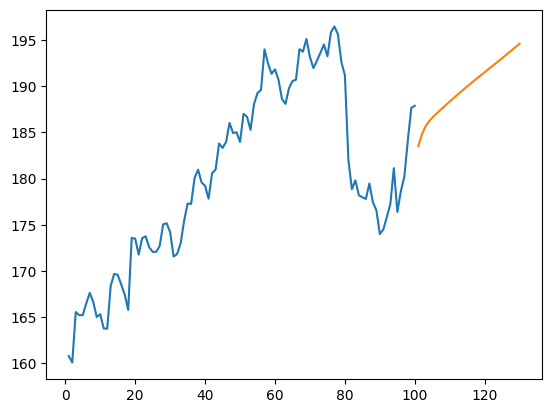

In [217]:
plt.plot(day_new,scaler.inverse_transform(df1[1157:]))
plt.plot(day_pred,scaler.inverse_transform(lst_output))

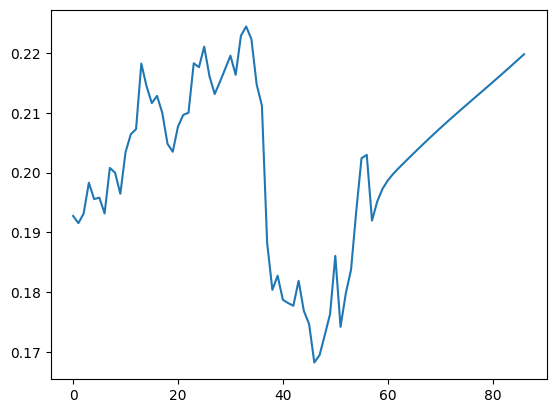

In [218]:
df3=df1.tolist()
df3.extend(lst_output)
plt.plot(df3[1200:])

In [219]:
df3=scaler.inverse_transform(df3).tolist()

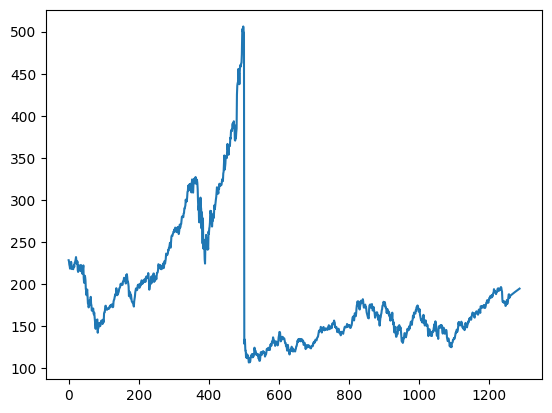

In [220]:
plt.plot(df3)